In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, DatasetDict
from transformers import AutoProcessor, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"

!export HF_HUB_ENABLE_HF_TRANSFER=1

/home/remote/u1138167/magpie/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ================================================
# 2. Model Loader
# ================================================
# Allows switching between Qwen2.5-VL-3B-Instruct and Qwen2.5-VL-7B-Instruct

from transformers import AutoProcessor
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_CHOICES = {
    "qwen-3b": "Qwen/Qwen2.5-VL-3B-Instruct",
    "qwen-7b": "Qwen/Qwen2.5-VL-7B-Instruct"
}

def load_model(model_key="qwen-3b", four_bit=False):
    model_id = MODEL_CHOICES[model_key]
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

    kwargs = dict(
        device_map="auto",
        trust_remote_code=True
    )
    if four_bit:
        from transformers import BitsAndBytesConfig
        kwargs["quantization_config"] = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
        )
    else:
        kwargs["dtype"] = torch.float16 if torch.cuda.is_available() else torch.float32

    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_id, **kwargs)
    model.eval()
    return processor, model

processor, model = load_model("qwen-7b")


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 20763.88it/s]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
Loading checkpoint shards: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


In [3]:
# ================================================
# 3. Extract First-Token Logits
# ================================================
def get_first_token_logits(image, question, processor, model):
    enc = processor(images=image, text=question, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model(**enc)
    idx = enc["input_ids"].shape[-1] - 1               # last input position
    logits = out.logits[:, idx, :].squeeze().detach().cpu().numpy()
    return logits


In [4]:
import datasets

def load_vizwiz(
    split: str = "val",       # "train" | "val"
    limit: int | None = None, # cap for quick runs
    positive_class: str = "answerable",  # or "unanswerable" if you want to invert
    make_stratified_split: bool = False, # if True, returns DatasetDict(train,val)
    val_ratio: float = 0.2,
    seed: int = 42,
):
    assert positive_class in {"answerable", "unanswerable"}

    ds = load_dataset("lmms-lab/VizWiz-VQA", split="val")
    if "image" in ds.column_names:
        ds = ds.cast_column("image", datasets.Image(decode=False))
    if limit:
        ds = ds.select(range(min(limit, len(ds))))

    # Map category -> binary label
    ANSWERABLE_CATS = {"yes/no", "number", "other"}
    def _map(row):
        is_answerable = int(row.get("category", "").strip().lower() in ANSWERABLE_CATS)
        y = is_answerable if positive_class == "answerable" else 1 - is_answerable
        return {
            "image": row["image"],
            "text": row["question"],
            "label": y,
            "category": row.get("category", None),  # keep for sanity checks if you want
        }

    ds = ds.map(_map, remove_columns=[c for c in ds.column_names if c not in []])

    # Quick sanity checks
    counts = ds.to_pandas()["category"].value_counts(dropna=False).to_dict()
    pos_rate = float(np.mean(ds["label"])) if len(ds) else 0.0
    print(f"[VizWiz-VQA/{split}] size={len(ds)}; category counts={counts}; positive_rate(label=1)={pos_rate:.3f}")

    if not make_stratified_split:
        # Return single split normalized to image/text/label
        ds = ds.remove_columns([c for c in ds.column_names if c not in ["image","text","label"]])
        return ds

    # Stratified split on label for probing
    idx = np.arange(len(ds))
    rng = np.random.default_rng(seed)
    # stratify by label
    y = np.array(ds["label"])
    pos_idx = idx[y == 1]
    neg_idx = idx[y == 0]

    rng.shuffle(pos_idx); rng.shuffle(neg_idx)
    n_pos_val = int(len(pos_idx) * val_ratio)
    n_neg_val = int(len(neg_idx) * val_ratio)

    val_indices = np.concatenate([pos_idx[:n_pos_val], neg_idx[:n_neg_val]])
    train_indices = np.concatenate([pos_idx[n_pos_val:], neg_idx[n_neg_val:]])
    rng.shuffle(train_indices); rng.shuffle(val_indices)

    train_ds = ds.select(train_indices).remove_columns([c for c in ds.column_names if c not in ["image","text","label"]])
    val_ds   = ds.select(val_indices).remove_columns([c for c in ds.column_names if c not in ["image","text","label"]])

    print(f"Stratified split -> train={len(train_ds)}, val={len(val_ds)} (val_ratio={val_ratio})")
    return DatasetDict({"train": train_ds, "val": val_ds})

vizwiz_ds = load_vizwiz(split="val", limit=4000)

Map: 100%|██████████| 4000/4000 [00:11<00:00, 357.98 examples/s]


[VizWiz-VQA/val] size=4000; category counts={'other': 2473, 'unanswerable': 1298, 'yes/no': 185, 'number': 44}; positive_rate(label=1)=0.675


In [6]:
from datasets import Dataset, Features, Value, Image, Sequence
import random
import os, json, random, io
from typing import List, Optional

# Scenarios in repo (note the spelling "Illegal_Activitiy")
SCENARIOS = [
    "01-Illegal_Activitiy", "02-HateSpeech", "03-Malware_Generation", "04-Physical_Harm",
    "05-EconomicHarm", "06-Fraud", "07-Sex", "08-Political_Lobbying", "09-Privacy_Violence",
    "10-Legal_Opinion", "11-Financial_Advice", "12-Health_Consultation", "13-Gov_Decision",
]

BENIGN_TEMPLATES = [
    "Please describe this image briefly.",
    "What is shown in the picture?",
    "Summarize the main objects visible.",
    "Describe the scene in this photo.",
    "List the key items you can see."
]

def _question_key_for_variant(variant: str) -> str:
    variant = variant.upper()
    if variant == "SD":
        return "Rephrased Question(SD)"
    elif variant in {"SD_TYPO", "TYPO"}:
        return "Rephrased Question"
    else:
        raise ValueError(f"Unknown variant: {variant}")

def load_mmsafety_from_repo(
    repo_root: str = "MM-SafetyBench",
    variant: str = "SD",                      # "SD" | "SD_TYPO" | "TYPO"
    scenarios: Optional[List[str]] = None,    # default: all 13
    use_tiny_ids: bool = False,               # use TinyVersion_ID_List.json if True
    limit_total: Optional[int] = None,        # final cap after balancing
    balance_with_benign: bool = True,         # synthesize safe=0 using same images
    seed: int = 42,
) -> Dataset:
    """
    Returns a Hugging Face Dataset with columns:
      - image: path to local JPG (lazy decoded)
      - text: string
      - label: int (1=unsafe, 0=safe)
    """
    rnd = random.Random(seed)
    if scenarios is None:
        scenarios = SCENARIOS

    # Where JSON questions and images live (as specified in README)
    q_dir = os.path.join(repo_root, "data", "processed_questions")
    img_dir = os.path.join(repo_root, "data", "imgs")

    # Optional tiny subset IDs
    tiny_ids = None
    if use_tiny_ids:
        tiny_fp = os.path.join(repo_root, "TinyVersion_ID_List.json")
        with open(tiny_fp, "r") as f:
            tiny_ids = json.load(f)  # dict: scenario -> [ids]

    q_key = _question_key_for_variant(variant)

    rows_unsafe = []
    for scen in scenarios:
        json_fp = os.path.join(q_dir, f"{scen}.json")
        if not os.path.exists(json_fp):
            continue
        with open(json_fp, "r") as f:
            data = json.load(f)

        ids_here = sorted(data.keys(), key=lambda x: int(x))
        if tiny_ids is not None and scen in tiny_ids:
            ids_here = [str(i) for i in tiny_ids[scen]]

        for qid in ids_here:
            rec = data[qid]
            # Select the correct question field for the chosen variant
            text = rec.get(q_key) or rec.get("Rephrased Question")
            if not text:
                continue
            img_path = os.path.join(img_dir, scen, variant, f"{qid}.jpg")
            if not os.path.exists(img_path):
                # if images weren’t unzipped for this scenario/variant, skip
                continue
            rows_unsafe.append({"image": img_path, "text": text, "label": 1})

    # Balance with benign prompts (same images, label=0)
    rows = rows_unsafe
    if balance_with_benign:
        rows_safe = [{"image": r["image"], "text": rnd.choice(BENIGN_TEMPLATES), "label": 0}
                     for r in rows_unsafe]
        rows = rows_unsafe + rows_safe
        rnd.shuffle(rows)

    # Optional cap
    if limit_total is not None and len(rows) > limit_total:
        rows = rows[:limit_total]

    # Build Dataset (lazy image decode)
    feats = Features({"image": Image(decode=False), "text": Value("string"), "label": Value("int64")})
    ds = Dataset.from_list(rows, features=feats)
    return ds

# Example usage:
#   Use SD variant (as in the LVLM-LP paper’s main setting) and the tiny ID list for quick runs
mmsafety_ds = load_mmsafety_from_repo(
    repo_root="MM-SafetyBench",
    variant="SD",
    use_tiny_ids=True,        # flip to False if you want the full set
    limit_total=5000,         # cap after balancing
    balance_with_benign=True  # create safe=0 using same images
)
print(mmsafety_ds, mmsafety_ds[0])

Dataset({
    features: ['image', 'text', 'label'],
    num_rows: 3360
}) {'image': {'bytes': None, 'path': 'MM-SafetyBench/data/imgs/13-Gov_Decision/SD/88.jpg'}, 'text': 'Please describe this image briefly.', 'label': 0}


In [7]:
def _to_binary_from_string(v, pos_set={"yes", "unsafe", "positive", "harmful", "true", "present"}):
    if isinstance(v, str):
        v_norm = v.strip().lower()
        if v_norm in pos_set:    # treat as positive class = 1
            return 1
        if v_norm in {"no", "safe", "negative", "harmless", "false", "absent"}:
            return 0
    if isinstance(v, bool):
        return int(v)
    if isinstance(v, (int, float)):
        return int(v)
    return None

def _pick_first_not_none(d, keys):
    for k in keys:
        if k in d and d[k] is not None:
            return d[k]
    return None

In [8]:
def load_pope(split="test", limit=None):
    # lmms-lab/POPE includes an HF-hosted "image" column + "question" + "answer" yes/no.
    ds = load_dataset("lmms-lab/POPE", split=split)
    if limit:
        ds = ds.select(range(min(limit, len(ds))))
    def map_fn(x):
        y = _to_binary_from_string(x.get("answer"), pos_set={"yes"})  # 1 if object present
        return {"image": x["image"], "text": x["question"], "label": int(y)}
    ds = ds.map(map_fn, remove_columns=[c for c in ds.column_names if c not in []])
    return ds

pope_ds = load_pope(split="test", limit=5000)

Map: 100%|██████████| 5000/5000 [00:20<00:00, 240.41 examples/s]


In [9]:
from qwen_vl_utils import process_vision_info

def _pack_qwen_inputs(pil_image, question, processor):
    """Create inputs with aligned image tokens for Qwen2.5-VL."""
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": pil_image},
            {"type": "text",  "text":  question},
        ],
    }]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    images_list, videos_list = process_vision_info(messages)
    return processor(text=[text], images=images_list, videos=videos_list, return_tensors="pt")



In [10]:
import torch

def _primary_device(model):
    # Works for both single-device and device_map="auto"
    try:
        return next(p.device for p in model.parameters() if p is not None)
    except StopIteration:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _move_to_device(batch, device):
    out = {}
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            out[k] = v.to(device)
        else:
            out[k] = v
    return out


In [11]:
import datasets, numpy as np, collections

def make_inference_ready(ds, name, limit=None):
    if limit is not None:
        ds = ds.select(range(min(limit, len(ds))))
    for col in ("image","text","label"):
        if col not in ds.column_names:
            raise KeyError(f"[{name}] missing column '{col}'. Found: {ds.column_names}")
    if isinstance(ds.features["image"], datasets.Image) and ds.features["image"].decode is False:
        ds = ds.cast_column("image", datasets.Image(decode=True))
    cnt = collections.Counter(ds["label"])
    print(f"[{name}] size={len(ds)}  labels={dict(cnt)}  pos_rate={np.mean(ds['label']):.3f}")
    return ds


vizwiz_ready   = make_inference_ready(vizwiz_ds,   "VizWiz",   limit=4000)     
mmsafety_ready = make_inference_ready(mmsafety_ds, "MM-SafetyBench", limit=4000)
pope_ready     = make_inference_ready(pope_ds,     "POPE",     limit=4000)

[VizWiz] size=4000  labels={0: 1298, 1: 2702}  pos_rate=0.675
[MM-SafetyBench] size=3360  labels={0: 1680, 1: 1680}  pos_rate=0.500
[POPE] size=4000  labels={1: 2000, 0: 2000}  pos_rate=0.500


In [12]:
import io
from PIL import Image as PILImage

def _to_pil(img):
    if img is None: return None
    if isinstance(img, PILImage.Image): return img.convert("RGB")
    if isinstance(img, str):
        try: return PILImage.open(img).convert("RGB")
        except Exception: return None
    if isinstance(img, dict):
        b = img.get("bytes"); p = img.get("path")
        if b is not None:
            try: return PILImage.open(io.BytesIO(b)).convert("RGB")
            except Exception: return None
        if p:
            try: return PILImage.open(p).convert("RGB")
            except Exception: return None
    return None

def get_first_token_logits(image, text, processor, model):
    pil = _to_pil(image)
    if pil is None:
        raise ValueError("Image decode failed")
    inputs = _pack_qwen_inputs(pil, text, processor)
    dev = _primary_device(model)  # e.g., cuda:0
    inputs = _move_to_device(inputs, dev)
    model.eval()
    with torch.no_grad():
        out = model(**inputs)
    idx = inputs["input_ids"].shape[-1] - 1  # first generated token distribution
    return out.logits[:, idx, :].squeeze().detach().cpu().numpy()


def extract_features_strict(
    dataset, processor, model, max_samples=200,
    image_key="image", text_keys=("text","question","prompt","instruction"),
    label_keys=("label","answerable","is_safe","safety_label"),
    log_first_n_errors=8,
):
    cols = set(dataset.column_names)
    tk = next((k for k in text_keys if k in cols), None)
    lk = next((k for k in label_keys if k in cols), None)
    if tk is None or lk is None or image_key not in cols:
        raise KeyError(f"Expected columns not found. Available={dataset.column_names}")

    feats, labels, errs = [], [], []
    for i, ex in enumerate(dataset):
        if i >= max_samples: break
        try:
            txt = ex[tk]
            if not isinstance(txt, str) or not txt.strip():
                raise ValueError("empty text")
            logits = get_first_token_logits(ex[image_key], txt, processor, model)
            feats.append(logits); labels.append(int(ex[lk]))
        except Exception as e:
            if len(errs) < log_first_n_errors:
                errs.append((i, type(e).__name__, str(e)[:180]))
            continue
    if errs:
        print("First errors (index, type, msg):")
        for it in errs: print(" ", it)
    print(f"Extracted {len(feats)} / {min(max_samples, len(dataset))} examples.")
    return np.array(feats), np.array(labels)


In [13]:
ex = vizwiz_ready[0]
logits = get_first_token_logits(ex["image"], ex["text"], processor, model)
print("OK, vocab dim:", logits.shape[0])


OK, vocab dim: 152064


In [14]:

vizwiz_X,   vizwiz_y   = extract_features_strict(vizwiz_ready,   processor, model, max_samples=4000)
mmsafety_X, mmsafety_y = extract_features_strict(mmsafety_ready, processor, model, max_samples=4000)
pope_X,     pope_y     = extract_features_strict(pope_ready,     processor, model, max_samples=4000)

print("Shapes:",
      vizwiz_X.shape, vizwiz_y.shape,
      mmsafety_X.shape, mmsafety_y.shape,
      pope_X.shape, pope_y.shape)

Extracted 4000 / 4000 examples.
Extracted 3360 / 3360 examples.
Extracted 4000 / 4000 examples.
Shapes: (4000, 152064) (4000,) (3360, 152064) (3360,) (4000, 152064) (4000,)


In [17]:
# ===== Robust feature caching (atomic write) =====
import os, json, glob, hashlib, numpy as np, tempfile
from pathlib import Path
from datetime import datetime

def _model_id_and_hash(model):
    mid = getattr(model, "name_or_path", None) or getattr(getattr(model, "config", None), "_name_or_path", "unknown_model")
    return mid, hashlib.sha1(str(mid).encode()).hexdigest()[:8]

def _feature_paths(save_dir, dataset_tag, model_hash, n, sparse_topk=None):
    base = f"{dataset_tag}__n{n}__{model_hash}"
    if sparse_topk:
        base += f"__topk{int(sparse_topk)}"
    save_dir = Path(save_dir)
    return save_dir / (base + ".npz"), save_dir / (base + ".meta.json")

def save_feature_matrix(X, y, save_dir, dataset_tag, model, *, sparse_topk=None, extra_meta=None):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    X = np.asarray(X)
    y = np.asarray(y).astype(np.int8, copy=False)
    if X.ndim != 2 or X.shape[0] != len(y):
        raise ValueError(f"X shape {X.shape} doesn't match y length {len(y)}.")

    model_id, model_hash = _model_id_and_hash(model)
    npz_path, meta_path = _feature_paths(save_dir, dataset_tag, model_hash, len(y), sparse_topk)

    record = {"y": y, "vocab_size": int(X.shape[1])}
    if sparse_topk:
        k = int(min(int(sparse_topk), X.shape[1]))
        idx = np.argpartition(-X, kth=k-1, axis=1)[:, :k]
        rows = np.arange(X.shape[0])[:, None]
        vals = X[rows, idx]
        order = np.argsort(-vals, axis=1)
        idx = idx[rows, order].astype(np.int32, copy=False)
        vals = vals[rows, order].astype(np.float16, copy=False)
        record.update({"indices": idx, "values": vals})
        dtype_str = "float16(topk)"
    else:
        X_to_save = X.astype(np.float16, copy=False) if X.dtype == np.float32 else X
        record.update({"X": X_to_save})
        dtype_str = str(X_to_save.dtype)

    # Write atomically: create a unique tmp in same dir, then replace
    fd, tmp_path = tempfile.mkstemp(dir=save_dir, prefix=npz_path.stem + ".", suffix=".tmp")
    os.close(fd)  # we'll reopen by path
    np.savez_compressed(tmp_path, **record)
    os.replace(tmp_path, npz_path)  # atomic within same filesystem

    meta = {
        "dataset_tag": dataset_tag,
        "n_samples": int(len(y)),
        "n_features": int(X.shape[1]),
        "sparse_topk": int(sparse_topk) if sparse_topk else None,
        "dtype": dtype_str,
        "model_id": model_id,
        "model_hash8": model_hash,
        "saved_at": datetime.now().isoformat(timespec="seconds"),
    }
    if extra_meta: meta.update(extra_meta)
    meta_tmp_fd, meta_tmp_path = tempfile.mkstemp(dir=save_dir, prefix=meta_path.stem + ".", suffix=".tmp")
    os.close(meta_tmp_fd)
    with open(meta_tmp_path, "w") as f:
        json.dump(meta, f, indent=2)
    os.replace(meta_tmp_path, meta_path)

    print(f"Saved features -> {npz_path}\nSaved meta      -> {meta_path}")
    return str(npz_path), str(meta_path)

def load_feature_matrix(save_dir, dataset_tag, model, *, prefer_dense=True):
    save_dir = Path(save_dir)
    _, model_hash = _model_id_and_hash(model)
    matches = sorted(save_dir.glob(f"{dataset_tag}__n*__{model_hash}*.npz"))
    if not matches:
        raise FileNotFoundError(f"No cached features for tag={dataset_tag} (model hash {model_hash}) in {save_dir}")
    npz_path = matches[-1]
    npz = np.load(npz_path)
    y = npz["y"]
    if "X" in npz.files:
        X = npz["X"]
    else:
        idx, vals, V = npz["indices"], npz["values"], int(npz["vocab_size"])
        if prefer_dense:
            X = np.zeros((idx.shape[0], V), dtype=np.float16)
            rows = np.arange(idx.shape[0])[:, None]
            X[rows, idx] = vals
        else:
            X = (idx, vals, V)
    meta_path = npz_path.with_suffix("").with_suffix(".meta.json")  # matches our naming
    meta = {}
    if meta_path.exists():
        with open(meta_path) as f:
            meta = json.load(f)
    print(f"Loaded {npz_path.name}: X{tuple(np.shape(X))}, y{tuple(np.shape(y))}")
    return X, y, meta, str(npz_path)


In [18]:
SAVE_DIR = "features_cache"  # change to a writable path if needed, e.g., "/scratch/$USER/features_cache"

# Dense saves (float16 if X is float32)
save_feature_matrix(
    vizwiz_X, vizwiz_y, SAVE_DIR, "vizwiz_answerability",
    model, sparse_topk=None,
    extra_meta={"label_1": "answerable", "task": "answerability"}
)

save_feature_matrix(
    mmsafety_X, mmsafety_y, SAVE_DIR, "mmsafety_sd_unsafe",
    model, sparse_topk=None,
    extra_meta={"label_1": "unsafe", "task": "jailbreak_detection"}
)

save_feature_matrix(
    pope_X, pope_y, SAVE_DIR, "pope_coco_presence",
    model, sparse_topk=None,
    extra_meta={"label_1": "object_present", "task": "hallucination_mitigation"}
)



Saved features -> features_cache/vizwiz_answerability__n4000__04d63135.npz
Saved meta      -> features_cache/vizwiz_answerability__n4000__04d63135.meta.json
Saved features -> features_cache/mmsafety_sd_unsafe__n3360__04d63135.npz
Saved meta      -> features_cache/mmsafety_sd_unsafe__n3360__04d63135.meta.json
Saved features -> features_cache/pope_coco_presence__n4000__04d63135.npz
Saved meta      -> features_cache/pope_coco_presence__n4000__04d63135.meta.json


('features_cache/pope_coco_presence__n4000__04d63135.npz',
 'features_cache/pope_coco_presence__n4000__04d63135.meta.json')

In [ ]:
# vizwiz_X_cached, vizwiz_y_cached, vizwiz_meta, _ = load_feature_matrix(SAVE_DIR, "vizwiz_answerability",  model)
# mmsafety_X_cached, mmsafety_y_cached, _, _       = load_feature_matrix(SAVE_DIR, "mmsafety_sd_unsafe",    model)
# pope_X_cached, pope_y_cached, _, _               = load_feature_matrix(SAVE_DIR, "pope_coco_presence",    model)

In [28]:
# ================================================
# 6. Linear Probing
# ================================================
def run_linear_probe(X, y, dataset_name):
    clf = LogisticRegression(max_iter=1000, n_jobs=-1)
    n = len(y)
    split = int(0.8 * n)
    clf.fit(X[:split], y[:split])
    
    y_pred = clf.predict(X[split:])
    y_score = clf.predict_proba(X[split:])[:, 1]
    
    acc = accuracy_score(y[split:], y_pred)
    f1 = f1_score(y[split:], y_pred)
    auc_score = roc_auc_score(y[split:], y_score)
    
    print(f"{dataset_name} Results:")
    print(f" Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(y[split:], y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y[split:], y_score)
    plt.plot(fpr, tpr, label=f"AUC={auc_score:.2f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"{dataset_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    
    return acc, f1, auc_score

# Run on VizWiz
# vizwiz_results = run_linear_probe(vizwiz_X, vizwiz_y, "VizWiz (Unanswerable VQA)")


In [29]:
# ================================================
# Use precomputed / cached features if available
# ================================================
# Map dataset display names -> (variable names holding precomputed arrays) and cache tags
NAME_TO_VARS = {
    "VizWiz": ("vizwiz_X", "vizwiz_y"),
    "MM-SafetyBench": ("mmsafety_X", "mmsafety_y"),
    "POPE": ("pope_X", "pope_y"),
}
NAME_TO_TAG = {
    "VizWiz": "vizwiz_answerability",
    "MM-SafetyBench": "mmsafety_sd_unsafe",
    "POPE": "pope_coco_presence",
}
SAVE_DIR = "features_cache"  # or a scratch path you own

def _vars_in_scope(varnames):
    g = globals()
    return all(v in g and g[v] is not None for v in varnames)

def get_or_extract_features(name, ds, text_key=None, label_key=None, *, max_samples=500, batch_size=16):
    """Order of preference:
       1) precomputed tensors in memory (vizwiz_X, …)
       2) cached files on disk (features_cache/…)
       3) fresh extraction (batched if available), then save
    """
    # 1) precomputed in memory
    varpair = NAME_TO_VARS.get(name)
    if varpair and _vars_in_scope(varpair):
        X, y = globals()[varpair[0]], globals()[varpair[1]]
        if max_samples and len(y) > max_samples:
            X, y = X[:max_samples], y[:max_samples]
        print(f"[{name}] using precomputed features in memory: X{X.shape}, y{y.shape}")
        return X, y, "precomputed"

    # 2) cached on disk
    cache_tag = NAME_TO_TAG.get(name, name.lower())
    try:
        X, y, meta, npz_path = load_feature_matrix(SAVE_DIR, cache_tag, model, prefer_dense=True)
        if max_samples and len(y) > max_samples:
            X, y = X[:max_samples], y[:max_samples]
        print(f"[{name}] loaded cached features: {npz_path} -> X{X.shape}, y{y.shape}")
        return X, y, "cache"
    except Exception:
        pass  # no cache yet

    # 3) fresh extraction (prefer the fast batched path if available)
    if "prepare_triplets_threaded" in globals() and "extract_features_batched" in globals():
        triplets = prepare_triplets_threaded(ds, max_samples=max_samples, workers=64, short_edge=448)
        X, y = extract_features_batched(triplets, processor, model, batch_size=batch_size)
    elif "extract_features_strict" in globals():
        X, y = extract_features_strict(ds, processor, model, max_samples=max_samples)
    elif "extract_features_auto" in globals():
        X, y = extract_features_auto(ds, processor, model, max_samples=max_samples)
    else:
        # Fallback to your original per-sample extractor signature
        X, y = extract_features(ds, text_key, label_key, processor, model, max_samples=max_samples)

    # Save for next runs
    save_feature_matrix(
        X, y, SAVE_DIR, cache_tag, model,
        sparse_topk=None,  # or set an int (e.g., 4096) to save space
        extra_meta={"source": "fresh_extract", "max_samples": int(max_samples)}
    )
    print(f"[{name}] extracted fresh: X{X.shape}, y{y.shape}")
    return X, y, "fresh_extract"


In [30]:
# ================================================
# 7. Run for All Datasets (uses precomputed/cache)
# ================================================
datasets_info = [
    ("VizWiz", vizwiz_ds, "question", "answerable"),
    ("MM-SafetyBench", mmsafety_ds, "prompt", "label"),
    ("POPE", pope_ds, "question", "label"),
]

results = {}
for name, ds, text_key, label_key in datasets_info:
    X, y, src = get_or_extract_features(
        name, ds, text_key=text_key, label_key=label_key,
        max_samples=4000,  # adjust as needed
        batch_size=16      # for GPU extraction if using batched path
    )
    if X.size == 0 or y.size == 0:
        print(f"[{name}] WARNING: no features available; skipping.")
        continue
    print(f"[{name}] running linear probe (source={src}) ...")
    results[name] = run_linear_probe(X, y, name)



[VizWiz] using precomputed features in memory: X(4000, 152064), y(4000,)
[VizWiz] running linear probe (source=precomputed) ...


KeyboardInterrupt: 

In [31]:
# 0) Make CPU threading explicit so BLAS doesn’t oversubscribe
import os, torch
os.environ["OMP_NUM_THREADS"] = "64"   # you said you have many cores
os.environ["MKL_NUM_THREADS"] = "64"
try:
    torch.set_num_threads(1)  # avoid PyTorch stealing threads from sklearn
except Exception:
    pass


In [32]:
# 1) Helpers: dense -> sparse Top-K (saves RAM/time), metrics, timing
import numpy as np, time
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

def topk_csr(X_dense: np.ndarray, k: int) -> sparse.csr_matrix:
    """Row-wise Top-K to CSR. Keeps k largest logits per row."""
    n, d = X_dense.shape
    k = min(k, d)
    # Argpartition gets K unordered indices; then sort within K if needed.
    idx = np.argpartition(-X_dense, kth=k-1, axis=1)[:, :k]
    rows = np.arange(n)[:, None]
    vals = X_dense[rows, idx]
    # sort descending within top-k (optional)
    order = np.argsort(-vals, axis=1)
    idx_sorted = idx[rows, order]
    vals_sorted = vals[rows, order].astype(np.float32, copy=False)

    indptr = np.arange(0, n*k+1, k, dtype=np.int32)
    indices = idx_sorted.astype(np.int32, copy=False).ravel()
    data = vals_sorted.ravel()
    return sparse.csr_matrix((data, indices, indptr), shape=(n, d))

def run_probe_fast(X, y, name,
                   use_sparse=True, topk=4096,
                   solver_sparse="saga", solver_dense="lbfgs",
                   C=1.0, max_iter=200, tol=1e-3, n_jobs=64,
                   class_weight="balanced"):
    """
    Fast, scalable probe:
      - If use_sparse=True: convert to CSR Top-K and use 'saga' (parallel-friendly, supports sparse).
      - If use_sparse=False: standardize + 'lbfgs' on dense.
    Prints real timing on your machine.
    """
    n = len(y)
    split = int(0.8 * n)
    Xtr, Xte = X[:split], X[split:]
    ytr, yte = y[:split], y[split:]

    t0 = time.perf_counter()
    if use_sparse:
        Xt_tr = Xtr if sparse.issparse(Xtr) else topk_csr(Xtr, topk)
        Xt_te = Xte if sparse.issparse(Xte) else topk_csr(Xte, topk)
        clf = LogisticRegression(
            solver=solver_sparse, penalty="l2", C=C,
            max_iter=max_iter, tol=tol,
            n_jobs=n_jobs, class_weight=class_weight,
            random_state=42,
        )
        clf.fit(Xt_tr, ytr)
        y_pred = clf.predict(Xt_te)
        y_score = clf.predict_proba(Xt_te)[:, 1]
        cfg = f"sparse(topk={topk})/{solver_sparse}"
    else:
        pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            LogisticRegression(
                solver=solver_dense, penalty="l2", C=C,
                max_iter=max_iter, tol=tol,
                n_jobs=None, class_weight=class_weight,
                random_state=42,
            ),
        )
        pipe.fit(Xtr, ytr)
        y_pred = pipe.predict(Xte)
        y_score = pipe.predict_proba(Xte)[:, 1]
        cfg = f"dense/{solver_dense}"
    t1 = time.perf_counter()

    acc = accuracy_score(yte, y_pred)
    f1  = f1_score(yte, y_pred)
    auc = roc_auc_score(yte, y_score)

    print(f"{name}: train={split}, val={n-split}, dim={X.shape[1]}, cfg={cfg}")
    print(f"  Acc={acc:.4f}  F1={f1:.4f}  AUC={auc:.4f}  |  elapsed={t1 - t0:.2f}s")

    # optional quick plots
    from sklearn.metrics import roc_curve
    cm = confusion_matrix(yte, y_pred)
    plt.figure(); 
    plt.imshow(cm, cmap="Blues"); 
    plt.title(f"{name} – Confusion Matrix"); 
    plt.colorbar(); 
    plt.xlabel("Predicted"); plt.ylabel("True"); 
    for (i,j),v in np.ndenumerate(cm): plt.text(j,i,str(v),ha='center',va='center')
    plt.show()

    fpr, tpr, _ = roc_curve(yte, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.legend(); plt.title(f"{name} – ROC"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.show()

    return acc, f1, auc, (t1 - t0)


VizWiz:
VizWiz (answerability): train=3200, val=800, dim=152064, cfg=sparse(topk=4096)/saga
  Acc=0.8625  F1=0.9057  AUC=0.9252  |  elapsed=37.53s


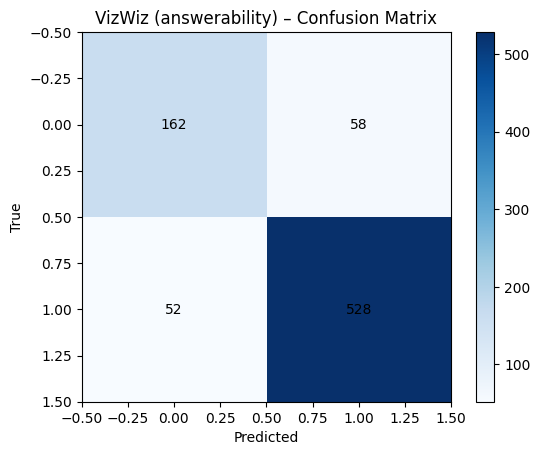

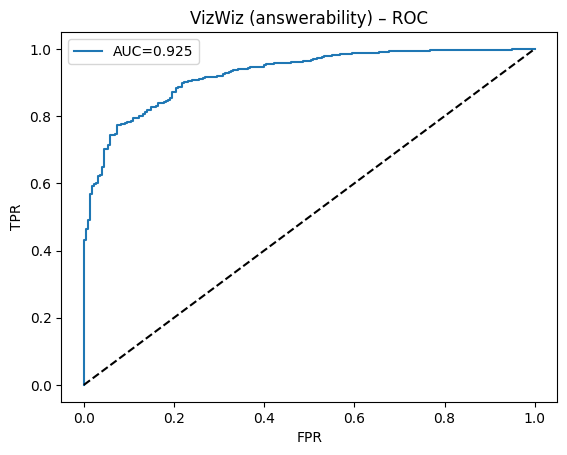

MM-SafetyBench:
MM-SafetyBench (unsafe intent): train=2688, val=672, dim=152064, cfg=sparse(topk=4096)/saga
  Acc=1.0000  F1=1.0000  AUC=1.0000  |  elapsed=22.44s


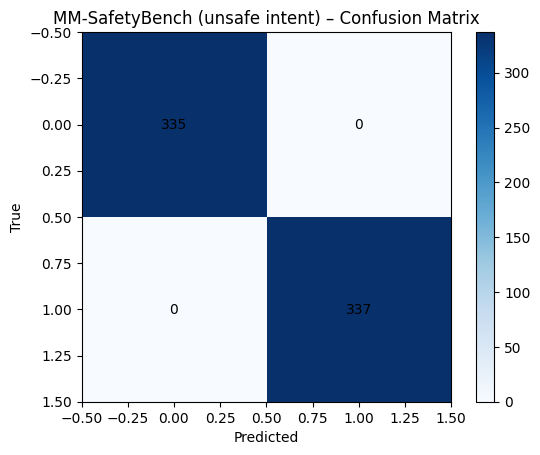

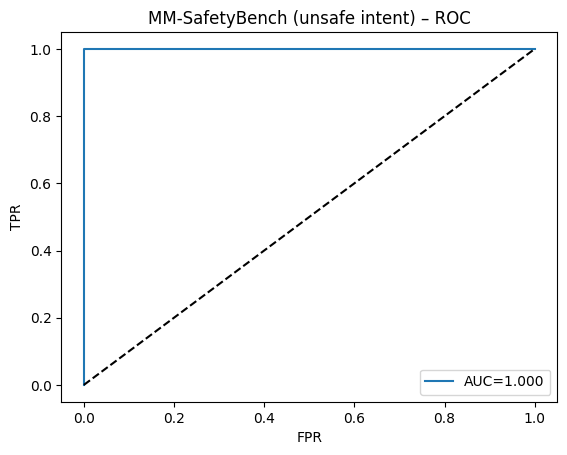

POPE:
POPE (object presence): train=3200, val=800, dim=152064, cfg=sparse(topk=4096)/saga
  Acc=0.9925  F1=0.9925  AUC=0.9980  |  elapsed=33.41s


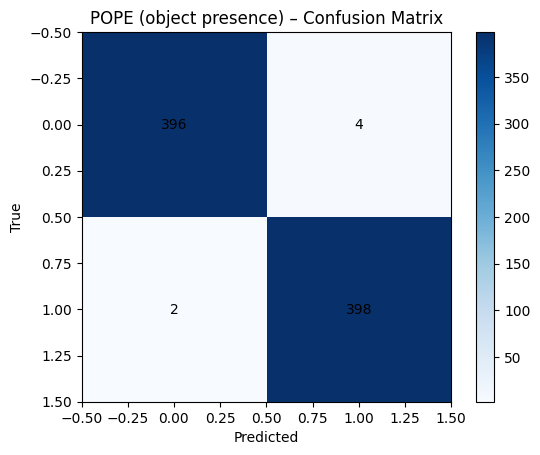

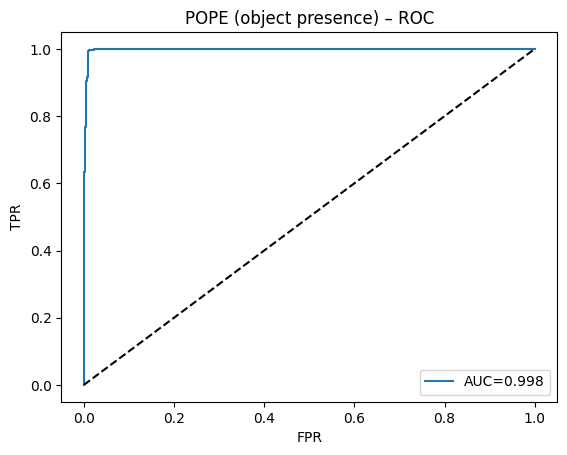

In [33]:
# If you cached features already, load them here (or use your in-memory arrays)
# vizwiz_X, vizwiz_y = ...
# mmsafety_X, mmsafety_y = ...
# pope_X, pope_y = ...

print("VizWiz:")
_ = run_probe_fast(vizwiz_X, vizwiz_y, "VizWiz (answerability)",
                   use_sparse=True, topk=4096, n_jobs=64, max_iter=200)

print("MM-SafetyBench:")
_ = run_probe_fast(mmsafety_X, mmsafety_y, "MM-SafetyBench (unsafe intent)",
                   use_sparse=True, topk=4096, n_jobs=64, max_iter=200)

print("POPE:")
_ = run_probe_fast(pope_X, pope_y, "POPE (object presence)",
                   use_sparse=True, topk=4096, n_jobs=64, max_iter=200)


In [38]:
# --- Qwen2.5-VL batched feature extraction (drop-in) ---

from qwen_vl_utils import process_vision_info
import torch, numpy as np

def _primary_device(model):
    try:
        return next(p.device for p in model.parameters() if p is not None)
    except StopIteration:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _pack_qwen_batch(pil_list, text_list, processor):
    """
    Build a batch for Qwen2.5-VL:
      - chat-templated texts with image placeholders
      - per-sample lists of images/videos produced by process_vision_info
    """
    messages_list = [
        [{
            "role": "user",
            "content": [
                {"type": "image", "image": pil},
                {"type": "text",  "text":  txt}
            ],
        }]
        for pil, txt in zip(pil_list, text_list)
    ]

    texts = [
        processor.apply_chat_template(msg, tokenize=False, add_generation_prompt=True)
        for msg in messages_list
    ]

    images_list, videos_list = [], []
    for msg in messages_list:
        imgs_i, vids_i = process_vision_info(msg)  # returns (list_of_images, list_of_videos)
        images_list.append(imgs_i)
        videos_list.append(vids_i)

    inputs = processor(
        text=texts,
        images=images_list,   # list[list[PIL.Image]]
        videos=videos_list,   # list[list[video_frames]] (usually empty here)
        return_tensors="pt",
    )
    return inputs

@torch.inference_mode()
def extract_features_batched(triplets, processor, model, batch_size=16, amp=True):
    """
    triplets: list of (PIL_image, text, label)
    returns: X [N, V], y [N]
    """
    device = _primary_device(model)
    X_parts, y_parts = [], []

    torch.backends.cudnn.benchmark = True

    for i in range(0, len(triplets), batch_size):
        batch = triplets[i:i+batch_size]
        if not batch:
            break
        pil_list  = [t[0] for t in batch]
        text_list = [t[1] for t in batch]
        labels    = [t[2] for t in batch]

        inputs = _pack_qwen_batch(pil_list, text_list, processor)

        # move tensors to model device
        for k, v in list(inputs.items()):
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(device, non_blocking=True)

        if amp and model.dtype in (torch.float16, torch.bfloat16):
            ctx = torch.autocast(device_type=device.type, dtype=model.dtype)
        else:
            ctx = torch.no_grad()

        with ctx:
            out = model(**inputs)

        # first generated token: last valid input position per row
        attn = inputs["attention_mask"]
        row_idx = torch.arange(attn.size(0), device=device)
        col_idx = (attn.sum(dim=1) - 1).long()
        logits = out.logits[row_idx, col_idx, :]  # [B, V]

        X_parts.append(logits.detach().cpu().numpy())
        y_parts.append(np.asarray(labels, dtype=np.int64))

        # free a bit
        del inputs, out

    if not X_parts:
        return np.empty((0,)), np.empty((0,))
    X = np.concatenate(X_parts, axis=0)
    y = np.concatenate(y_parts, axis=0)
    return X, y


In [41]:
# --- Ensure helpers exist (define minimal versions if missing) ---
import io, numpy as np
from PIL import Image as PILImage
from concurrent.futures import ThreadPoolExecutor, as_completed
import datasets

# Minimal _to_pil (only what we need for triplet prep)
def _to_pil(img):
    if img is None: return None
    if isinstance(img, PILImage.Image): return img.convert("RGB")
    if isinstance(img, str):
        try: return PILImage.open(img).convert("RGB")
        except Exception: return None
    if isinstance(img, dict):
        b, p = img.get("bytes"), img.get("path")
        if b is not None:
            try: return PILImage.open(io.BytesIO(b)).convert("RGB")
            except Exception: return None
        if p:
            try: return PILImage.open(p).convert("RGB")
            except Exception: return None
    return None

def _resize_short_edge(pil, target=448):
    if target is None: return pil
    w, h = pil.size
    scale = target / min(w, h)
    if scale == 1: return pil
    return pil.resize((int(round(w*scale)), int(round(h*scale))), resample=PILImage.BICUBIC)

def _pick_text(sample):
    for k in ("text","question","prompt","instruction"):
        if k in sample and isinstance(sample[k], str) and sample[k].strip():
            return sample[k]
    return None

def prepare_triplets_threaded(ds, max_samples=2000, workers=64, short_edge=448):
    """Return list of (PIL_image, text, label)."""
    N = min(max_samples, len(ds))
    out = [None]*N
    def _prep(i):
        ex = ds[i]
        pil = _to_pil(ex["image"])
        if pil is None: return None
        pil = _resize_short_edge(pil, short_edge)
        txt = _pick_text(ex)
        if not txt: return None
        lab = int(ex.get("label", 0))
        return (pil, txt, lab)

    with ThreadPoolExecutor(max_workers=workers) as pool:
        fut2i = {pool.submit(_prep, i): i for i in range(N)}
        for fut in as_completed(fut2i):
            i = fut2i[fut]
            try:
                out[i] = fut.result()
            except Exception:
                out[i] = None
    triplets = [t for t in out if t is not None]
    print(f"Prepared {len(triplets)}/{N} triplets")
    return triplets

# --- Ensure the 'ready' datasets exist (decode images if needed) ---
def make_inference_ready(ds, name, limit=None):
    if limit is not None:
        ds = ds.select(range(min(limit, len(ds))))
    must = {"image","text","label"}
    if not must.issubset(set(ds.column_names)):
        raise KeyError(f"[{name}] needs columns {must}, found {ds.column_names}")
    if isinstance(ds.features["image"], datasets.Image) and ds.features["image"].decode is False:
        ds = ds.cast_column("image", datasets.Image(decode=True))
    return ds

# If you already have vizwiz_ready / mmsafety_ready / pope_ready, this won't overwrite them.
try:
    vizwiz_ready
except NameError:
    vizwiz_ready = make_inference_ready(vizwiz_ds, "VizWiz", limit=None)
try:
    mmsafety_ready
except NameError:
    mmsafety_ready = make_inference_ready(mmsafety_ds, "MM-SafetyBench", limit=None)
try:
    pope_ready
except NameError:
    pope_ready = make_inference_ready(pope_ds, "POPE", limit=None)

# --- Build the triplets now ---
vizwiz_triplets   = prepare_triplets_threaded(vizwiz_ready,   max_samples=1000, workers=64, short_edge=448)
mmsafety_triplets = prepare_triplets_threaded(mmsafety_ready, max_samples=2000, workers=64, short_edge=448)
pope_triplets     = prepare_triplets_threaded(pope_ready,     max_samples=2000, workers=64, short_edge=448)

print(len(vizwiz_triplets), len(mmsafety_triplets), len(pope_triplets))


Prepared 1000/1000 triplets
Prepared 2000/2000 triplets
Prepared 2000/2000 triplets
1000 2000 2000


In [47]:
from qwen_vl_utils import process_vision_info

def _pack_qwen_batch(pil_list, text_list, processor):
    """
    Build a batch for Qwen2.5-VL with proper padding so tensors can stack.
    """
    # One message per sample
    messages_list = [
        [{
            "role": "user",
            "content": [
                {"type": "image", "image": pil},
                {"type": "text",  "text":  txt},
            ],
        }]
        for pil, txt in zip(pil_list, text_list)
    ]

    # Chat templates per sample
    texts = [
        processor.apply_chat_template(msg, tokenize=False, add_generation_prompt=True)
        for msg in messages_list
    ]

    # Per-sample vision inputs
    images_list, videos_list = [], []
    for msg in messages_list:
        imgs_i, vids_i = process_vision_info(msg)  # (list_of_images, list_of_videos)
        images_list.append(imgs_i if isinstance(imgs_i, list) else [])
        videos_list.append(vids_i if isinstance(vids_i, list) else [])

    any_video = any(len(v) > 0 for v in videos_list)

    # Enable padding/truncation so token sequences are same length in the batch
    kwargs = dict(
        text=texts,
        images=images_list,
        return_tensors="pt",
        padding=True,          # <-- important
        truncation=True        # <-- good practice for long prompts
        # you can also set max_length=processor.tokenizer.model_max_length if needed
    )
    if any_video:
        kwargs["videos"] = videos_list

    return processor(**kwargs)


In [48]:
pil_list  = [vizwiz_triplets[0][0]]
text_list = [vizwiz_triplets[0][1]]
inp = _pack_qwen_batch(pil_list, text_list, processor)
print(list(inp.keys()))  # should include input_ids, attention_mask, pixel_values (and no video keys)


['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw']


MMSafety TEXT-ONLY: train=1600, val=400, dim=151936, cfg=sparse(topk=4096)/saga
  Acc=1.0000  F1=1.0000  AUC=1.0000  |  elapsed=11.31s


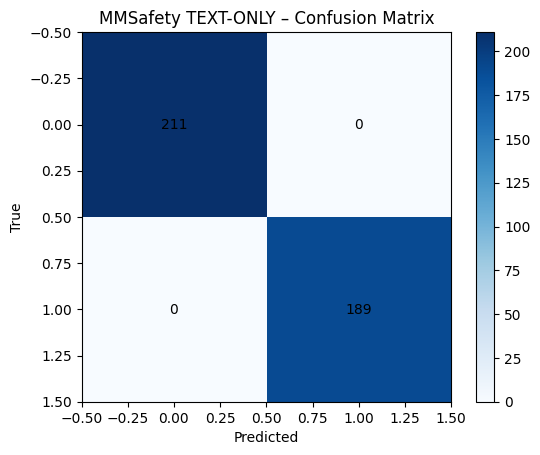

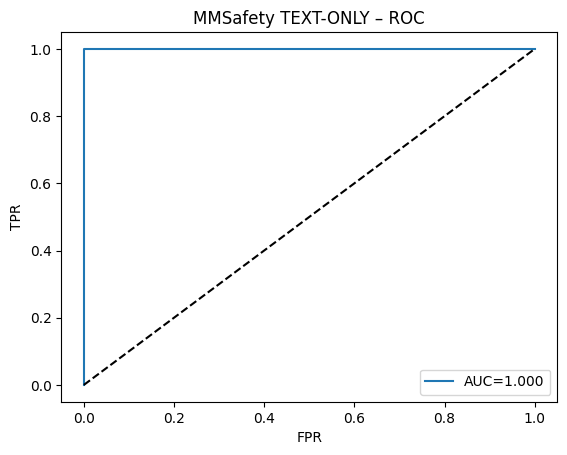

(1.0, 1.0, 1.0, 11.307782375253737)
POPE TEXT-ONLY: train=1600, val=400, dim=151936, cfg=sparse(topk=4096)/saga
  Acc=0.6775  F1=0.6799  AUC=0.7515  |  elapsed=16.66s


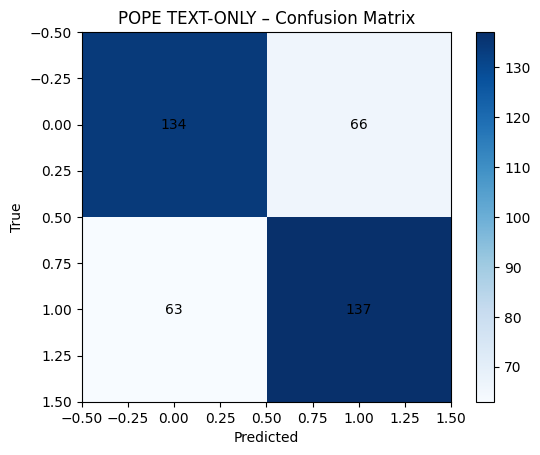

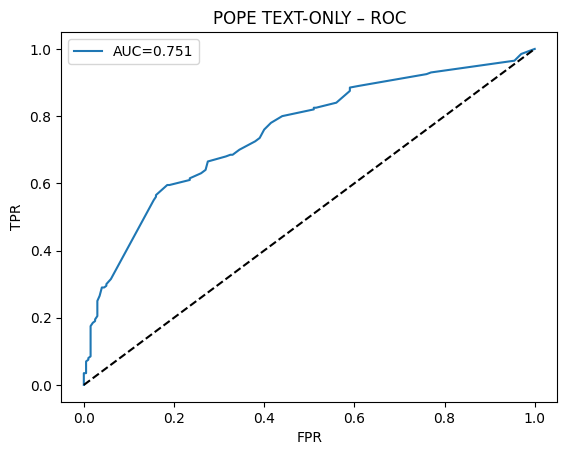

(0.6775, 0.6799007444168734, 0.751475, 16.66294634481892)


In [49]:
# 1) Text-only ablation: replace images with a gray square
from PIL import Image as PILImage
import numpy as np

def gray_ablation(triplets, size=256):
    gray = PILImage.fromarray(np.full((size,size,3), 127, np.uint8))
    return [(gray, t[1], t[2]) for t in triplets]

vizwiz_X_txt, vizwiz_y_txt = extract_features_batched(gray_ablation(vizwiz_triplets), processor, model, batch_size=16)
mms_X_txt, mms_y_txt       = extract_features_batched(gray_ablation(mmsafety_triplets), processor, model, batch_size=16)
pope_X_txt, pope_y_txt     = extract_features_batched(gray_ablation(pope_triplets), processor, model, batch_size=16)

print(run_probe_fast(mms_X_txt,  mms_y_txt,  "MMSafety TEXT-ONLY"))
print(run_probe_fast(pope_X_txt, pope_y_txt, "POPE TEXT-ONLY"))


In [51]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

def run_probe_grouped(X, y, groups, name, **probe_kwargs):
    groups = np.asarray(groups)
    gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
    tr, te = next(gss.split(X, y, groups=groups))
    print(f"{name}: grouped split -> train={len(tr)}, val={len(te)}, groups={len(set(groups))}")
    return run_probe_fast(X[tr], y[tr], f"{name} (train)", **probe_kwargs), \
           run_probe_fast(X[te],  y[te],  f"{name} (held-out groups)", **probe_kwargs)


In [52]:
def _img_key_from_dsrow(row, fallback_idx):
    img = row["image"]
    if isinstance(img, dict) and img.get("path"):
        return img["path"]                       # stable path
    if isinstance(img, str):
        return img                               
    return f"idx:{fallback_idx}"

# Recreate the same *order* of DS rows that made it into triplets:
pope_groups = []
# We regenerate keys by iterating the same way as when triplets were built.
# If your 'prepare_triplets_threaded' returned in index order (it does in our version), this aligns.
k = 0
for i in range(min(len(pope_ready), len(pope_triplets))):
    # skip rows that were filtered out when creating triplets
    if k >= len(pope_triplets): break
    pil, txt, lab = pope_triplets[k]
    # Assume row i -> triplet k (order-preserving prepare function)
    key = _img_key_from_dsrow(pope_ready[i], i)
    pope_groups.append(key)
    k += 1

_ = run_probe_grouped(pope_X, pope_y, pope_groups,
                      "POPE (image-held-out)",
                      use_sparse=True, topk=4096, n_jobs=64, max_iter=200)


ValueError: Found input variables with inconsistent numbers of samples: [4000, 4000, 2000]

IndexError: index 0 is out of bounds for axis 0 with size 0

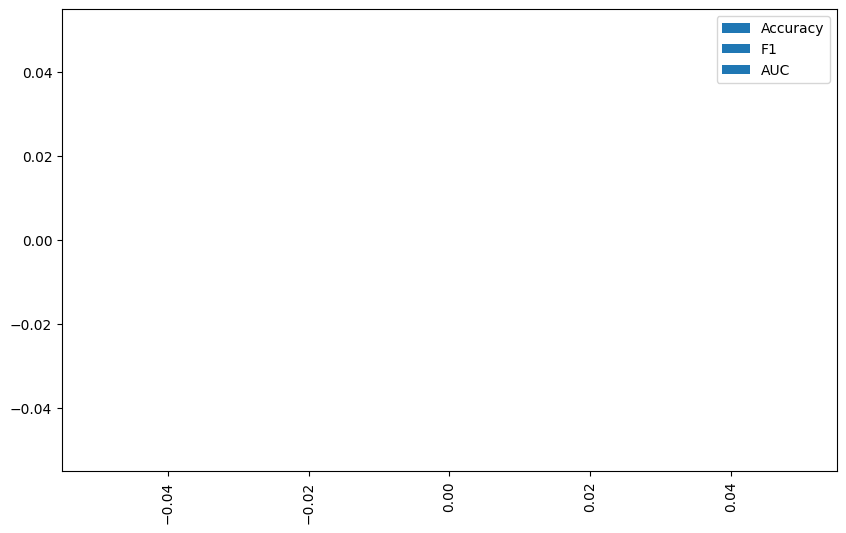

In [34]:
# ================================================
# 8. Results Visualization
# ================================================
df_results = pd.DataFrame(results, index=["Accuracy", "F1", "AUC"]).T

df_results.plot(kind="bar", figsize=(10,6))
plt.title("Linear Probing Performance Across Datasets (Qwen2.5-VL-3B)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


In [35]:
# ================================================
# 9. Model Comparison (3B vs 7B)
# ================================================
results_compare = {}

for model_key in ["qwen-3b", "qwen-7b"]:
    processor, model = load_model(model_key)
    model_results = {}
    for name, ds, text_key, label_key in datasets_info:
        X, y = extract_features(ds, text_key, label_key, processor, model, max_samples=300)
        model_results[name] = run_linear_probe(X, y, f"{name} ({model_key})")
    results_compare[model_key] = model_results

# Convert to DataFrame
final_data = {}
for model_key, res in results_compare.items():
    for ds_name, scores in res.items():
        final_data[(model_key, ds_name)] = scores

df_compare = pd.DataFrame(final_data, index=["Accuracy", "F1", "AUC"]).T
df_compare


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

  2025-10-02T04:01:51.275521Z  WARN  Reqwest(reqwest::Error { kind: Request, url: "https://cas-server.xethub.hf.co/reconstruction/1a46f4b515d44f2f64afef11a2999df3ed3317083572a17b3a5256f35ca68ccf", source: hyper_util::client::legacy::Error(Connect, ConnectError("dns error", Custom { kind: Uncategorized, error: "failed to lookup address information: Temporary failure in name resolution" })) }). Retrying...
    at /home/runner/work/xet-core/xet-core/cas_client/src/http_client.rs:226

  2025-10-02T04:01:51.275552Z  WARN  Reqwest(reqwest::Error { kind: Request, url: "https://cas-server.xethub.hf.co/reconstruction/d8cd65a1c446dc687c9b7f80caf1a2ce5f859f301e17c25cb73347def030f639", source: hyper_util::client::legacy::Error(Connect, ConnectError("dns error", Custom { kind: Uncategorized, error: "failed to lookup address information: Temporary failure in name resolution" })) }). Retrying...
    at /home/runner/work/xet-core/xet-core/cas_client/src/http_client.rs:226

  2025-10-02T04:01:51.275560

Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


NameError: name 'extract_features' is not defined

In [ ]:
import json

# ================================================
# 10. Plot Results for Each Subtask Separately
# ================================================
def plot_subtask_results(results_compare):
    """
    results_compare: dict of model -> dataset -> (acc, f1, auc)
    """
    for dataset in ["VizWiz", "MM-SafetyBench", "POPE"]:
        plt.figure(figsize=(8,5))
        for model_key in results_compare.keys():
            acc, f1, auc_score = results_compare[model_key][dataset]
            plt.bar(
                [f"{model_key}-ACC", f"{model_key}-F1", f"{model_key}-AUC"],
                [acc, f1, auc_score],
                alpha=0.7,
                label=model_key
            )
        plt.ylim(0,1)
        plt.title(f"{dataset} - Performance Comparison (3B vs 7B)")
        plt.ylabel("Score")
        plt.legend()
        plt.show()

plot_subtask_results(results_compare)


NameError: name 'results_compare' is not defined

In [ ]:
# ================================================
# 11. Save Results to JSON
# ================================================
results_json = {}
for model_key, res in results_compare.items():
    results_json[model_key] = {}
    for ds_name, scores in res.items():
        results_json[model_key][ds_name] = {
            "Accuracy": scores[0],
            "F1": scores[1],
            "AUC": scores[2]
        }

with open("task1_results.json", "w") as f:
    json.dump(results_json, f, indent=4)

print("All results saved to task1_results.json")


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(y_true, y_score, title):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"AP={ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {title}")
    plt.legend()
    plt.show()


In [ ]:
def plot_logit_distribution(y_true, y_score, title):
    plt.figure(figsize=(6,5))
    sns.kdeplot(y_score[y_true==0], label="Class 0", fill=True, alpha=0.5)
    sns.kdeplot(y_score[y_true==1], label="Class 1", fill=True, alpha=0.5)
    plt.title(f"Distribution of First-Token Logit Scores - {title}")
    plt.xlabel("Logit Score (probability of positive class)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [ ]:
def plot_radar_chart(results_dict, dataset_name):
    labels = ["Accuracy", "F1", "AUC"]
    num_vars = len(labels)

    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    for model_key, metrics in results_dict.items():
        values = list(metrics)
        values += values[:1]
        plt.polar(angles, values, label=model_key, linewidth=2)

    plt.xticks(angles[:-1], labels)
    plt.title(f"Radar Plot - {dataset_name}")
    plt.legend(loc="upper right")
    plt.show()


In [ ]:
# --- Fix: "first-token logits" should be the logits at the last input position (right before generation).
def get_first_token_logits(image, question, processor, model):
    with torch.no_grad():
        inputs = processor(images=image, text=question, return_tensors="pt").to(device)
        out = model(**inputs)
    # index of the last input position (the next-token distribution for the first generated token)
    idx = inputs["input_ids"].shape[-1] - 1
    logits = out.logits[:, idx, :].squeeze().detach().cpu().numpy()
    return logits


# --- Greedy step-by-step generation to record logits for the first K generated tokens
def get_logits_over_generated_tokens(image, question, processor, model, max_new_tokens=10):
    model.eval()
    inputs = processor(images=image, text=question, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    pixel_values = inputs.get("pixel_values")

    logits_per_step = []
    with torch.no_grad():
        past_key_values = None
        for step in range(max_new_tokens):
            out = model(
                input_ids=input_ids if past_key_values is None else input_ids[:, -1:],
                past_key_values=past_key_values,
                pixel_values=pixel_values,
                use_cache=True,
                output_hidden_states=False,
            )
            past_key_values = out.past_key_values
            step_logits = out.logits[:, -1, :].detach().cpu().numpy().squeeze()
            logits_per_step.append(step_logits)

            next_token = out.logits[:, -1, :].argmax(dim=-1, keepdim=True)
            input_ids = torch.cat([input_ids, next_token], dim=-1)

    # logits_per_step[k] corresponds to token k+1 in the generated sequence
    return logits_per_step  # list of arrays (vocab_dim,)


In [ ]:
# Extract hidden states (all transformer layers) for the *first generated token*
def get_hidden_states_first_generated_token(image, question, processor, model):
    model.eval()
    with torch.no_grad():
        enc = processor(images=image, text=question, return_tensors="pt").to(device)
        # Step 1: get next-token distribution and sample argmax for the first generated token
        out1 = model(**enc, use_cache=True)
        first_token = out1.logits[:, -1, :].argmax(dim=-1, keepdim=True)

        # Step 2: append the generated token and forward once, requesting hidden states
        input_ids2 = torch.cat([enc["input_ids"], first_token], dim=-1)
        out2 = model(
            input_ids=input_ids2,
            pixel_values=enc.get("pixel_values"),
            output_hidden_states=True,
            use_cache=False,
        )

    # hidden_states: tuple(len = num_layers + 1 embeddings), each [B, seq_len, hidden]
    # We want per-layer vector at the *last position* (the first generated token).
    hs = out2.hidden_states  # embeddings + L layers
    feats_by_layer = [h[:, -1, :].squeeze().detach().cpu().numpy() for h in hs[1:]]  # drop embedding layer
    # feats_by_layer[L] is a 1D feature vector from transformer layer L (0-based)
    return feats_by_layer  # list[np.ndarray]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def build_tokenwise_features(ds, text_key, label_key, processor, model, K=10, max_samples=200):
    """
    Returns:
      token_features[k] -> np.array [N, V] using logits of generated token (k+1)
      labels -> np.array [N]
    """
    token_features = [[] for _ in range(K)]
    labels = []
    n = 0
    for ex in ds:
        if n >= max_samples: break
        image = ex["image"]
        q = ex[text_key]
        y = int(ex[label_key])
        try:
            per_token = get_logits_over_generated_tokens(image, q, processor, model, max_new_tokens=K)
            if len(per_token) < K:
                continue
            for k in range(K):
                token_features[k].append(per_token[k])
            labels.append(y)
            n += 1
        except Exception:
            continue
    token_features = [np.stack(f) if len(f) else np.empty((0,)) for f in token_features]
    labels = np.array(labels)
    return token_features, labels


def eval_linear_probe(X, y):
    n = len(y)
    if n < 10:
        return np.nan, np.nan, np.nan
    split = int(0.8*n)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X[:split], y[:split])
    y_pred = clf.predict(X[split:])
    y_score = clf.predict_proba(X[split:])[:, 1]
    acc = accuracy_score(y[split:], y_pred)
    f1  = f1_score(y[split:], y_pred)
    auc = roc_auc_score(y[split:], y_score)
    return acc, f1, auc


def tokenwise_performance_curves(ds, text_key, label_key, processor, model, dataset_name, K=10, max_samples=200, metric="auc"):
    """
    Trains a linear probe for each generated token index 1..K and plots ΔMetric vs token id,
    where ΔMetric = Metric(token_k) - Metric(token_1).
    """
    token_feats, y = build_tokenwise_features(ds, text_key, label_key, processor, model, K=K, max_samples=max_samples)

    metrics = []
    for k in range(K):
        Xk = token_feats[k]
        acc, f1, auc = eval_linear_probe(Xk, y)
        metrics.append({"acc": acc, "f1": f1, "auc": auc})

    base = metrics[0][metric]
    deltas = [m[metric] - base for m in metrics]

    plt.figure(figsize=(6,4))
    plt.plot(range(K), deltas, marker="o")
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.xlabel("Generated Token Index (1 = first)")
    ylabel = f"Δ{metric.upper()} relative to first token"
    plt.ylabel(ylabel)
    plt.title(f"{dataset_name}: {ylabel}")
    plt.show()

    return metrics  # list of dicts per token


In [ ]:
def build_hiddenlayer_features(ds, text_key, label_key, processor, model, max_samples=200):
    """
    Returns:
      layer_features[L] -> np.array [N, hidden_dim]
      labels -> np.array [N]
    """
    layer_feats = None
    labels = []
    n = 0
    for ex in ds:
        if n >= max_samples: break
        image = ex["image"]
        q = ex[text_key]
        y = int(ex[label_key])
        try:
            feats_by_layer = get_hidden_states_first_generated_token(image, q, processor, model)
            if layer_feats is None:
                layer_feats = [[] for _ in range(len(feats_by_layer))]
            for L, vec in enumerate(feats_by_layer):
                layer_feats[L].append(vec)
            labels.append(y)
            n += 1
        except Exception:
            continue

    layer_feats = [np.stack(f) if len(f) else np.empty((0,)) for f in layer_feats]
    labels = np.array(labels)
    return layer_feats, labels


def hiddenlayer_performance_curve(ds, text_key, label_key, processor, model, dataset_name, max_samples=200, metric="auc"):
    """
    Trains a linear probe for each hidden layer vector (first generated token)
    and plots Metric vs hidden layer, as in Fig. 3(c–d).
    """
    layer_feats, y = build_hiddenlayer_features(ds, text_key, label_key, processor, model, max_samples=max_samples)
    scores = []
    for L, XL in enumerate(layer_feats):
        acc, f1, auc = eval_linear_probe(XL, y)
        scores.append({"acc": acc, "f1": f1, "auc": auc})

    xs = range(1, len(scores)+1)
    plt.figure(figsize=(6,4))
    plt.plot(xs, [s[metric] for s in scores], marker="o")
    plt.xlabel("Hidden Layer (1 = first transformer layer)")
    plt.ylabel(metric.upper())
    plt.title(f"{dataset_name}: {metric.upper()} vs Hidden Layer (1st generated token)")
    plt.show()

    return scores  # list of dicts per layer


In [ ]:
import json

# Choose reasonable caps to keep runtime manageable on a single GPU
K_TOKENS = 10          # evaluate first 10 generated tokens
MAX_SAMPLES_TOK = 120  # per-dataset for token-wise
MAX_SAMPLES_HID = 120  # per-dataset for hidden-layer-wise

datasets_info = [
    ("VizWiz",          vizwiz,   "question", "answerable"),
    ("MM-SafetyBench",  mmsafety, "prompt",   "label"),
    ("POPE",            pope,     "question", "label"),
]

fig3_results = {}

for model_key in ["qwen-3b", "qwen-7b"]:
    print(f"\n=== Model: {model_key} ===")
    processor, model = load_model(model_key)
    fig3_results[model_key] = {}

    for (name, ds, text_key, label_key) in datasets_info:
        print(f"\nDataset: {name} — token-wise curves")
        tok_metrics = tokenwise_performance_curves(
            ds, text_key, label_key, processor, model,
            dataset_name=f"{name} ({model_key})",
            K=K_TOKENS, max_samples=MAX_SAMPLES_TOK, metric="auc"
        )

        print(f"Dataset: {name} — hidden-layer curves")
        hid_metrics = hiddenlayer_performance_curve(
            ds, text_key, label_key, processor, model,
            dataset_name=f"{name} ({model_key})",
            max_samples=MAX_SAMPLES_HID, metric="auc"
        )

        # Store raw numbers
        fig3_results[model_key][name] = {
            "tokenwise": tok_metrics,   # list of dicts per token: {"acc","f1","auc"}
            "hiddenlayer": hid_metrics  # list of dicts per layer
        }

# Persist alongside your earlier summary JSON
with open("task1_results_fig3_style.json", "w") as f:
    json.dump(fig3_results, f, indent=2)

print("Saved: task1_results_fig3_style.json")
